# Part III: Generate KDEs and obtain persistence diagrams

- Compute the four cardinal directional distance transforms (distance to the closest cell wall along a given cardinal direction) for the cross section.
- Compute a KDE with a grid of stepsize `stepsize`
- Correct KDE boundaries: treat cell walls and nuclei as steep walls.
- Compute sub or superlevel persistence

Notice that the KDE itself is not saved, as it can easily computed again if necessary.
- Saving it would be quite expensive in the long run

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from glob import glob
import os
from scipy import ndimage, interpolate, spatial, stats

from KDEpy import FFTKDE
import gudhi as gd
import json
import persim

import utils
import matplotlib as mpl
from importlib import reload
from skimage import measure

dst = os.path.expanduser('~') + '/documents/writing/mcarto_figs/'

# Load all general data

- Same setup as in the previous notebooks

In [2]:
alphaNmax = 10
alphaNmin = 0.1
Cmap = 'plasma'
pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
pows2 = 2**np.arange(20) + 1
fs = 15
bw = 20
PP = 6
stepsize = 3
pp = 0
nuclei_mask_cutoff = 1
level = 'sub'

sample = 'D2'
wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep 

ksrc += sample + os.sep
isrc += sample + os.sep

#wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(tf.imread(wsrc + sample + '_dams.tif').astype(bool), ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = mpl.colors.ListedColormap(foo)

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')
transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
zmax = tlocs['Z'].max()
zmin = tlocs['Z'].min()

Detected 2937 cells
Detected 1365 nuclei


# Compute transcript weights for KDE

- If transcript is close to a border (cell wall or nucleus), it becomes heavier to then reflect the Gaussian "weight"
- Inspired from this thread in [crossvalidated](https://stats.stackexchange.com/questions/65866/good-methods-for-density-plots-of-non-negative-variables-in-r/).
- In this case, the weight variability is restrained: it will be at most `2`
- An unaffected transcript will have weight `1` instead.

![](https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/main/mcarto/figs/D2_GLYMA_05G092200_1749_1748_distance_transform.jpg)

# Select a cell and then a gene

- Get a nice bounding box to just focus on a given cell `cidx`
- A tri-color image `cell` is produced, where
    - `0` is for nuclei and walls
    - `1` for other cytoplasm
    - `2` for the cytosol of the specified cell 
- Produce a regular grid for that box of stepsize `stepsize`
- The grid extends beyond the box by a factor `pad` to account for numerical overflows when the computing KDE
- Get the transcripts of the gene inside that cell

In [3]:
tidx = 26
foo = metacell.loc[(metacell['nuclei_area'] == 0).values & (transcell.loc[transcriptomes[tidx]] > 500).values].copy()
#foo = foo.loc[np.intersect1d(foo.index.values, Cells)]
foo['xratio'] = np.minimum( (foo['length']/foo['height']).values, (foo['height']/foo['length']).values )
foo = foo[foo['xratio'] > 0.925]
print(foo.shape)
reps = foo.index.values
foo.sort_values(by=['xratio', 'total_area'], ascending=[False, True])

(35, 17)


,x0,x1,y0,y1,length,height,total_area,nuclei_area,cyto_area,c2t_area_ratio,number_nuclei,orig_comX,orig_comY,ndimage_comX,ndimage_comY,orig_cellID,xratio
ndimage_cellID,,,,,,,,,,,,,,,,,
2219,8410,8819,11834,12245,409,411,69460,0,69460,1.0,0,8615.34,12021.98,8614.85,12021.64,2221,0.995134
717,11983,12365,5495,5879,382,384,73815,0,73815,1.0,0,12180.19,5692.93,12179.69,5692.31,718,0.994792
784,12753,13181,5799,6223,428,424,122440,0,122440,1.0,0,12958.35,6020.55,12957.93,6020.04,785,0.990654
1860,9233,9638,10297,10706,405,409,118705,0,118705,1.0,0,9437.85,10508.79,9437.39,10508.24,1861,0.990220
493,6394,6780,4486,4866,386,380,84334,0,84334,1.0,0,6616.72,4694.43,6616.00,4693.70,494,0.984456
2011,9059,9464,10987,11399,405,412,102633,0,102633,1.0,0,9259.91,11197.56,9259.42,11197.05,2012,0.983010
708,11596,12071,5433,5899,475,466,130364,0,130364,1.0,0,11842.62,5669.78,11842.13,5669.24,708,0.981053
256,5396,5848,3264,3707,452,443,111129,0,111129,1.0,0,5623.20,3491.47,5622.65,3490.89,256,0.980088
2134,10728,11154,11475,11890,426,415,107695,0,107695,1.0,0,10954.29,11678.39,10953.63,11677.95,2133,0.974178


In [4]:
reload(utils)
SCALE = 16
coords = translocs[tidx].loc[:, ['X','Y']].values.T
KDE, hcells, hcoords, hextent, hpers, hlt = [ [None for _ in range(len(reps))] for _ in range(6) ]
for i in range(len(KDE)):
    cidx = reps[i]
    
    cmask = label[ coords[1], coords[0] ] == cidx
    
    hcoords[i] = translocs[tidx].loc[cmask, ['X','Y']].values.T
    
    hcells[i], hextent[i] = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, pxbar=False)
    
    axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, hcells[i], hextent[i], 0, stepsize, 
                                                                             cell_nuc, maxdims=(hcells[i].shape[1], hcells[i].shape[0]) )
    
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(hcoords[i].T).evaluate(grid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(hcoords[i])))
    kde[outside_walls] = 0
    kde = kde/(np.sum(kde)*(stepsize**len(hcoords[i])))
    
    KDE[i] = kde.reshape( list(map(len, axes))[::-1], order='F')
    hcells[i][pxbar] = -1

    cc = gd.CubicalComplex(top_dimensional_cells = utils.get_level_filtration(KDE[i], level) )
    pers = cc.persistence(homology_coeff_field=2, min_persistence=1e-15)
    hpers[i] = np.zeros((len(pers), 3), dtype=float)
    for k in range(len(hpers[i])):
        hpers[i][k, 0] = pers[k][0]
        hpers[i][k, 1:] = pers[k][1]

    hpers[i] = hpers[i][ np.all(hpers[i] < np.inf, axis=1), :]
    hpers[i] = pd.DataFrame(hpers[i], columns=['H','birth','death']).astype({'H':int})
    
    ld = [ None for _ in range(2) ]
    for k in range(len(ld)):
        ld[k] = np.zeros((len(hpers[i][hpers[i]['H'] == k]), 2))
        ld[k][:,0] = hpers[i].loc[hpers[i]['H'] == k, 'birth']
        ld[k][:,1] = hpers[i].loc[hpers[i]['H'] == k, 'death'] - hpers[i].loc[hpers[i]['H'] == k, 'birth']
    lt_max = np.max([np.max(ld[j]) for j in np.nonzero(list(map(len, ld)))[0] ])
    for k in range(len(ld)):
        ld[k] = ld[k]/lt_max * (SCALE-1)
        bar = ld[k][:,1] >= 1e-2
        ld[k] = ld[k][ bar ]
        
        hpers[i][ hpers[i]['H'] == k ] = hpers[i][ hpers[i]['H'] == k ].loc[bar]
    
    hpers[i].dropna(ignore_index=True, inplace=True)
    hlt[i] = ld

In [5]:
np.argsort( list(map(len, hpers)) )

array([ 2, 33, 27,  3, 24, 30, 15,  8, 16, 20,  7, 18, 34, 10, 21, 29, 28,
       26, 22,  5, 11,  6, 31, 19, 13,  0,  1, 14,  9, 32, 25, 17, 23, 12,
        4])

2352	(2, 720)	(6, 3)


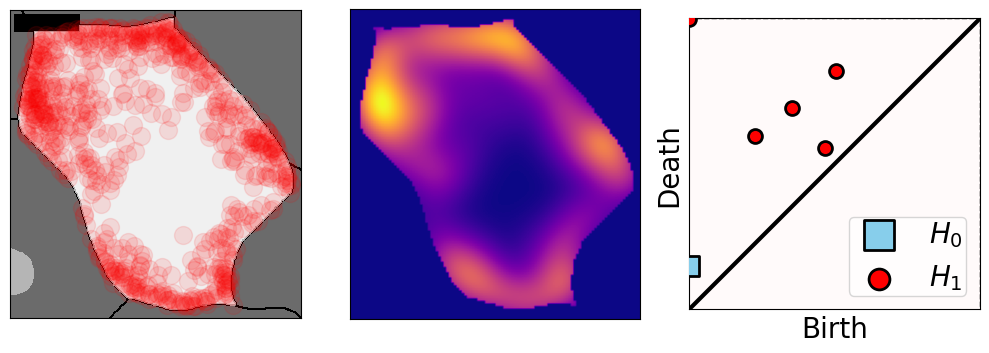

In [6]:
fs = 20
s,S = 15, 100
i = 33

print(reps[i], hcoords[i].shape, hpers[i].shape, sep='\t')
zthr = KDE[i].max()+1e-7
fig, ax = plt.subplots(1,3,figsize=(10,5))
ax = np.atleast_1d(ax).ravel(); j=0

ax[j].imshow(hcells[i]+1, cmap=cellular_cmap, origin='lower', extent=hextent[i], vmin=0, vmax=nnuc+2);
ax[j].scatter(*hcoords[i][:2], color='r', marker='o', alpha=max([ alphaNmin, min([1, alphaNmax/len(hcoords[i][0])])]), s=int(2e7/hcells[i].size))
ax[j].set_facecolor(wong[2])

j+=1
ax[j].imshow(KDE[i], origin='lower', cmap=Cmap, zorder=1)
ax[j].set_facecolor( mpl.colormaps[Cmap](0) )

j+=1
ax[j].axline((0,0), slope=1, c='k', lw=3, zorder=1)
ax[j].plot([0, zthr, zthr],[zthr, zthr, 0], lw=1, c='k', ls='--', zorder=2)
ax[j].set_xlim(0, zthr); ax[j].set_ylim(0, zthr)

h = hpers[i].loc[ (hpers[i]['H'] == 0) & (hpers[i]['birth'] <= zthr) & (hpers[i]['death'] <= zthr), ['birth','death']].values.T
h0 = ax[j].scatter(*h, marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
h = hpers[i].loc[ (hpers[i]['H'] == 1) & (hpers[i]['birth'] <= zthr) & (hpers[i]['death'] <= zthr), ['birth','death']].values.T
h1 = ax[j].scatter(*h, marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')

ax[j].set_xlabel('Birth', fontsize=fs)
ax[j].set_ylabel('Death', fontsize=fs)
ax[j].legend([h0,h1],['$H_0$', '$H_1$'], loc='lower right', fontsize=fs, borderpad=0.1, markerscale=1.5)
ax[j].set_facecolor('snow')

for j in range(len(ax)):
    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax[j].set_aspect('equal')
    

fig.tight_layout()

In [5]:
i = 33
cidx = reps[i]
kde = KDE[i].copy()
bd = hpers[i].copy()
lt = hlt[i].copy()
X, Y = np.meshgrid(range(kde.shape[1]), range(kde.shape[0]))

aux = bd.loc[bd['H'] == 0, 'birth'].min()
zthr = np.unique(bd.loc[:, ['birth', 'death']].values)+aux
azim = np.linspace(0, 360, len(zthr), endpoint=False)
argsort = np.argsort(np.argsort(bd.loc[:, ['birth', 'death']].values.ravel())).reshape(len(bd), 2, order='C')
border = [None for _ in range(len(zthr))]
for ii in range(len(border)):
    border[ii] = measure.find_contours(kde, level=zthr[ii])
    
print(len(zthr), aux, sep='\t')
(10e5*bd).round(2)

12	4.3266026803944434e-08


,H,birth,death
0,1000000.0,0.00,44.30
1,1000000.0,10.02,26.44
2,1000000.0,15.73,30.72
3,1000000.0,22.40,36.33
4,1000000.0,20.75,24.71
5,0.0,0.04,6.58


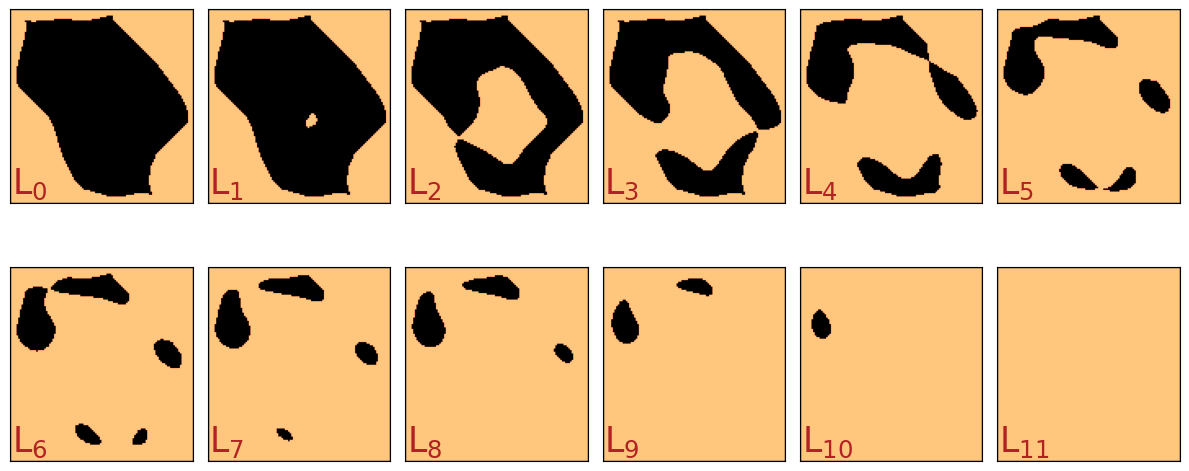

In [109]:
fig, ax = plt.subplots(2, 6, figsize=(12,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j=0

for j in range(min([len(ax), len(zthr)])):
    ax[j].imshow( kde < zthr[j], cmap='copper', origin='lower', vmin=0, vmax=1, zorder=1, extent=(0,kde.shape[1],0,kde.shape[0]))
    ax[j].set_xlim(0, kde.shape[1]); ax[j].set_ylim(0, kde.shape[0]);
    #ax[j].set_title(np.round(zthr[j]*10e5, 2), fontsize=fs)
    #ax[j].set_title('h$_{{{}}}$'.format(j), fontsize=fs)
    ax[j].text(1, 1, 'L$_{{{}}}$'.format(j), ha='left', va='bottom', fontsize=25, c='firebrick', fontname='sans')
    ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    ax[j].plot([0,kde.shape[1],kde.shape[1],0,0],[0,0,kde.shape[0],kde.shape[0],0], c='k', lw=1, zorder=3)

fig.tight_layout();

In [114]:
j = 1
for j in range(len(zthr)):
    fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel();
    
    ax[0].imshow( kde < zthr[j], cmap='copper', origin='lower', vmin=0, vmax=1, zorder=1, extent=(0,kde.shape[1],0,kde.shape[0]))
    ax[0].set_xlim(0, kde.shape[1]); ax[0].set_ylim(0, kde.shape[0]);
    ax[0].text(1, 1, 'L$_{{{}}}$'.format(j), ha='left', va='bottom', fontsize=85, c='firebrick', fontname='sans')
    ax[0].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    ax[0].plot([0,kde.shape[1],kde.shape[1],0,0],[0,0,kde.shape[0],kde.shape[0],0], c='k', lw=5, zorder=3)
    fig.tight_layout();
    
    filename = dst + '{}_c{}_{}level_{:02d}.pdf'.format(transcriptomes[tidx], cidx, level, j)
    fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight',transparent=False, pad_inches=0)
    plt.close()

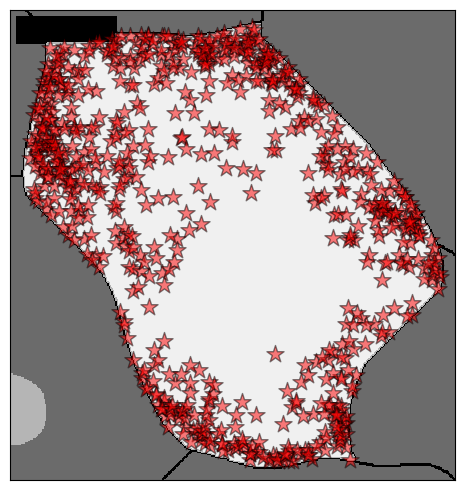

In [315]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel();

ax[j].imshow(hcells[i]+1, cmap=cellular_cmap, origin='lower', extent=hextent[i], vmin=0, vmax=nnuc+2);
ax[j].scatter(*hcoords[i][:2], color='r', marker='*', alpha=0.5, s=int(2e7/hcells[i].size), linewidth=1, edgecolor='k')
ax[j].set_facecolor(wong[2])

ax[0].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
fig.tight_layout();

filename = dst + '{}_c{}_{}level_cell.pdf'.format(transcriptomes[tidx], cidx, level)
fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight',transparent=False, pad_inches=0)
#plt.close()

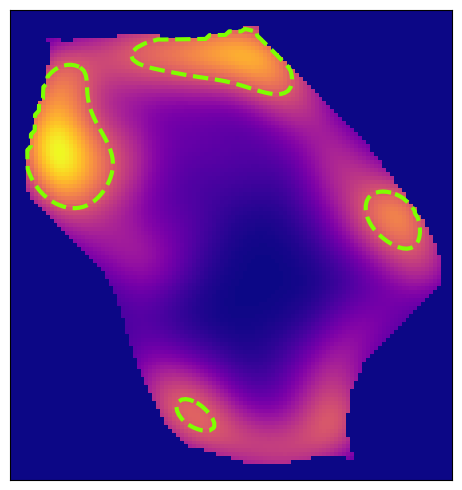

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].imshow(kde, origin='lower', cmap=Cmap, zorder=1)
for k in range(len(border)):
    ax[j].plot(border[k][:,1], border[k][:,0], c='chartreuse', ls='--', lw=3)

ax[j].set_facecolor( mpl.colormaps[Cmap](0) )
ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
fig.tight_layout();

filename = dst + '{}_c{}_{}level_kde.pdf'.format(transcriptomes[tidx], cidx, level)
#fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight',transparent=False, pad_inches=0)

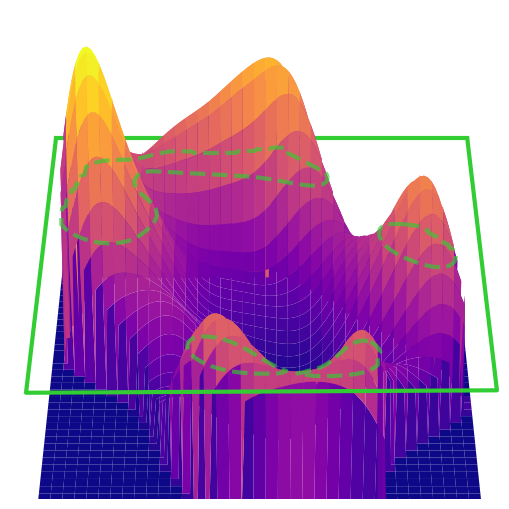

In [105]:
ii = 7
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(5,5))

ax.plot_surface(X, Y, kde, cmap=Cmap, alpha=1, zorder=2, vmin=0)

for k,ii in enumerate([5]):
    c = 'limegreen'
    ax.plot([0, kde.shape[1] ], [kde.shape[0], kde.shape[0]], np.repeat(zthr[ii]-aux, 2), 
            c=c, ls='-', lw=3, alpha=1, zorder=1)
    ax.plot([kde.shape[1],kde.shape[1],0,0], [kde.shape[0],1,0,kde.shape[0]], np.repeat(zthr[ii]-aux, 4), 
            c=c, ls='-', lw=3, alpha=1, zorder=3)
    for j in range(len(border[ii])):
        ax.plot(border[ii][j][:,1], border[ii][j][:,0], np.repeat(zthr[ii]-aux, len(border[ii][j])), c=c, ls='--', lw=3, zorder=3, alpha=0.65)

#ax.set_xlim(0, kde.shape[1])
#ax.set_ylim(0, kde.shape[0])
ax.set_zlim(0, zthr[-1])
ax.view_init(elev=35, azim=azim[9], roll=0)
ax.set_box_aspect(aspect=(4,4,3), zoom=1.6)
ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
ax.axis('off')

filename = dst + '{}_c{}_{}level_3dkde.pdf'.format(transcriptomes[tidx], cidx, level)
#fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight',transparent=False, pad_inches=0)

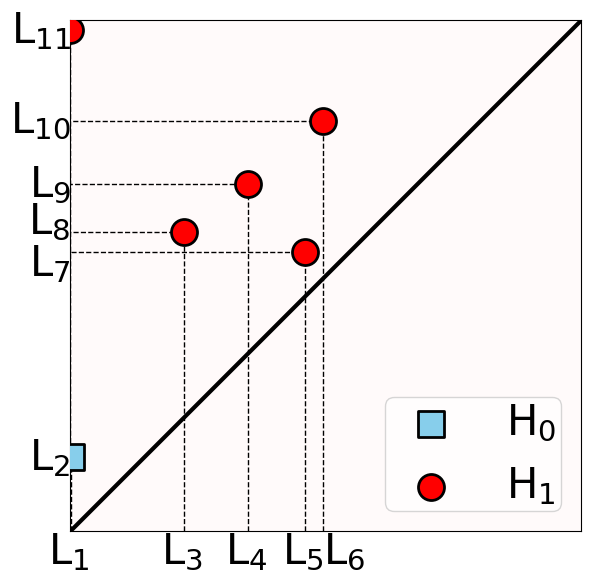

In [152]:
S = 350
fs = 30
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j=0

adj = np.zeros(argsort.shape)
adj[4,1] = -1e-6
adj[1,1] = 1e-6
adj[:,0] = -2e-6
adj[3,0] = 0
adj[0,0] = 3

ax[j].axline((0,0), slope=1, c='k', lw=3, zorder=1)
ax[j].set_xlim(0, zthr[-1]+20*aux); ax[j].set_ylim(0, zthr[-1]+aux*20)

h = bd.loc[bd['H'] == 0, ['birth', 'death'] ].values.T
h0 = ax[j].scatter(*h, marker='s', color='skyblue', edgecolor='k', linewidth=2, s=S, zorder=3, label='H$_0$')
h = bd.loc[bd['H'] == 1, ['birth', 'death'] ].values.T
h1 = ax[j].scatter(*h, marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='H$_1$')

#ax[j].set_xticks(bd['birth'].values[1:], ['L$_{{{}}}$'.format(k) for k in argsort[1:, 0]], fontsize=fs, fontname='sans', linespacing=0)
for k in range(len(bd)):
    ax[j].plot([bd.iloc[k,1], bd.iloc[k,1], 0], [0, bd.iloc[k,2], bd.iloc[k,2] ], lw=1, c='k', ls='--', zorder=2)

    if adj[k,0] < 1:
        ax[j].text(bd.iloc[k,1]+adj[k,0], aux, 'L$_{{{}}}$'.format(argsort[k,0]), ha='left', va='top', fontsize=fs, c='k')
    if adj[k,1] < 1:
        ax[j].text(aux, bd.iloc[k,2]+adj[k,1], 'L$_{{{}}}$'.format(argsort[k,1]), ha='right', va='center', fontsize=fs, c='k')

ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
ax[j].legend([h0,h1],['H$_0$', 'H$_1$'], loc='lower right', fontsize=fs, borderpad=0.1, markerscale=1)
ax[j].set_facecolor('snow')
ax[j].set_aspect('equal')

fig.tight_layout();

filename = dst + '{}_c{}_{}level_pd.pdf'.format(transcriptomes[tidx], cidx, level)
fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight', transparent=False, pad_inches=0.1)

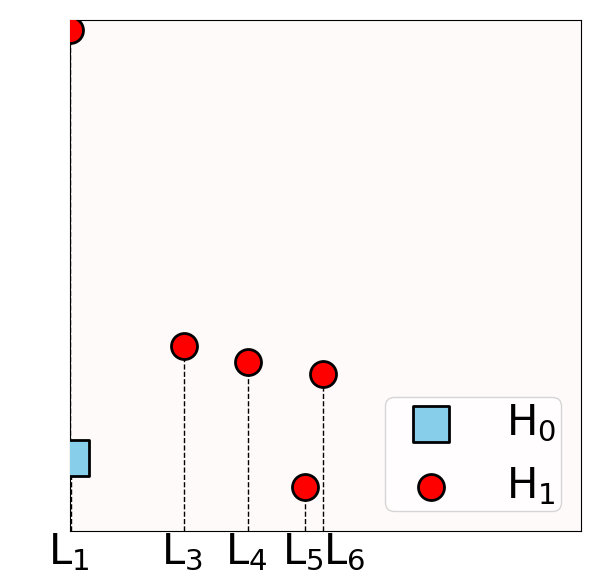

In [153]:
S = 350
fs = 30
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j=0

ax[j].set_xlim(0, zthr[-1]+20*aux); ax[j].set_ylim(0, zthr[-1]+aux*20)

h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h0 = ax[j].scatter(h[0], h[1]-h[0], marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='H$_0$')
h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h1 = ax[j].scatter(h[0], h[1]-h[0], marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='H$_1$')


for k in range(len(bd)):
    ax[j].plot([bd.iloc[k,1], bd.iloc[k,1]], [0, bd.iloc[k,2] - bd.iloc[k,1]], lw=1, c='k', ls='--', zorder=2)
    if adj[k,0] < 1:
        ax[j].text(bd.iloc[k,1]+adj[k,0], aux, 'L$_{{{}}}$'.format(argsort[k,0]), ha='left', va='top', fontsize=fs, c='k')
    if adj[k,1] < 1:
        ax[j].text(aux, bd.iloc[k,2]+adj[k,1], 'L$_{{{}}}$'.format(argsort[k,1]), ha='right', va='center', fontsize=fs, c='w', alpha=0)
        
ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
ax[j].legend([h0,h1],['H$_0$', 'H$_1$'], loc='lower right', fontsize=fs, borderpad=0.1, markerscale=1)
ax[j].set_facecolor('snow')
ax[j].set_aspect('equal')

fig.tight_layout();

filename = dst + '{}_c{}_{}level_lt.pdf'.format(transcriptomes[tidx], cidx, level)
fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight', transparent=False, pad_inches=0.1)

In [121]:
sigma = 1
persw = 1
pixsz = 1.5
iqr_factor = 1.5

pi_params = {'birth_range':(0, SCALE),
             'pers_range':(0, SCALE),
             'pixel_size': pixsz,
             'weight': 'persistence',
             'weight_params': {'n': persw},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }
                           
pimgr = persim.PersistenceImager(**pi_params)
pimg = np.asarray(pimgr.transform(lt, skew=False))
pimg_max = np.quantile(pimg[pimg > 0], 0.9999)
print(pimg.shape)

(2, 10, 10)


In [107]:
k = 0
for cmap,marker in zip(['Blues','Reds'],['s','o']):
    fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel(); j=0
    
    ax[j].imshow(pimg[k].T, origin='lower', cmap=cmap, vmin=-0.1*k*pimg_max, vmax=pimg_max/(4-3*k), extent=(0,len(pimg[k]),0,len(pimg[k])))
    ax[j].set_xlim(0, len(pimg[k])); ax[j].set_ylim(0, len(pimg[k]));
    ax[j].scatter( *((lt[k]/pixsz).T), marker=marker, facecolor='none', edgecolor='k', linewidth=2, s=S, zorder=4, ls=':')
    ax[j].text(.98*pimg[k].shape[1], .98*pimg[k].shape[0],'H$_{{{}}}$'.format(k), ha='right', va='top', fontsize=50, c='k')
    
    ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    ax[j].plot([0,len(pimg[k]),len(pimg[k]),0,0],[0,0,len(pimg[k]),len(pimg[k]),0], c='k', lw=3, zorder=3)
    
    fig.tight_layout()
    filename = dst + '{}_c{}_{}level_ps{}.pdf'.format(transcriptomes[tidx], cidx, level,k)
    fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight', transparent=False, pad_inches=0)
    plt.close()
    k+=1

In [146]:
k = 0
s = 22
for cmap,marker in zip(['Blues','Reds'],['s','o']):
    fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel(); j=0
    
    ax[j].imshow(pimg[k].T, origin='lower', cmap=cmap, vmin=-0.1*k*pimg_max, vmax=pimg_max/(4-3*k), extent=(0,len(pimg[k]),0,len(pimg[k])))
    ax[j].set_xlim(0, len(pimg[k])); ax[j].set_ylim(0, len(pimg[k]));
    
    ax[j].tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    ax[j].plot([0,len(pimg[k]),len(pimg[k]),0,0],[0,0,len(pimg[k]),len(pimg[k]),0], c='k', lw=3, zorder=3)
    for j in range(pimg[k].shape[0]):
        for l in range(pimg[k].shape[1]):
            val = 25*pimg[k,j,l]
            text = '{}'.format(int(val))
            foo = (l < pimg[k].shape[1] - 2) | (j < pimg[k].shape[0]-2) 
            if foo and (val > 1) and (val <= 75):
                ax[0].text(j+.5, l+.5, text, color='k', ha='center', va='center_baseline', weight='bold', size=s, zorder=4)
            elif foo and (val > 75):
                ax[0].text(j+.5, l+.5, text, color='yellow', ha='center', va='center_baseline', weight='bold', size=s, zorder=4)
            else:
                ax[0].text(j+.5, l+.5, text, color='gray', ha='center', va='center_baseline', weight='bold', size=s, zorder=4)
    
    ax[0].text(.98*pimg[k].shape[1], .98*pimg[k].shape[0],'H$_{{{}}}$'.format(k), ha='right', va='top', fontsize=50, c='k', zorder=5)
    
    fig.tight_layout()
    filename = dst + '{}_c{}_{}level_pi{}.pdf'.format(transcriptomes[tidx], cidx, level,k)
    fig.savefig(filename, format='pdf', dpi=100, bbox_inches='tight', transparent=False, pad_inches=0)
    plt.close()
    k+=1

# Animations

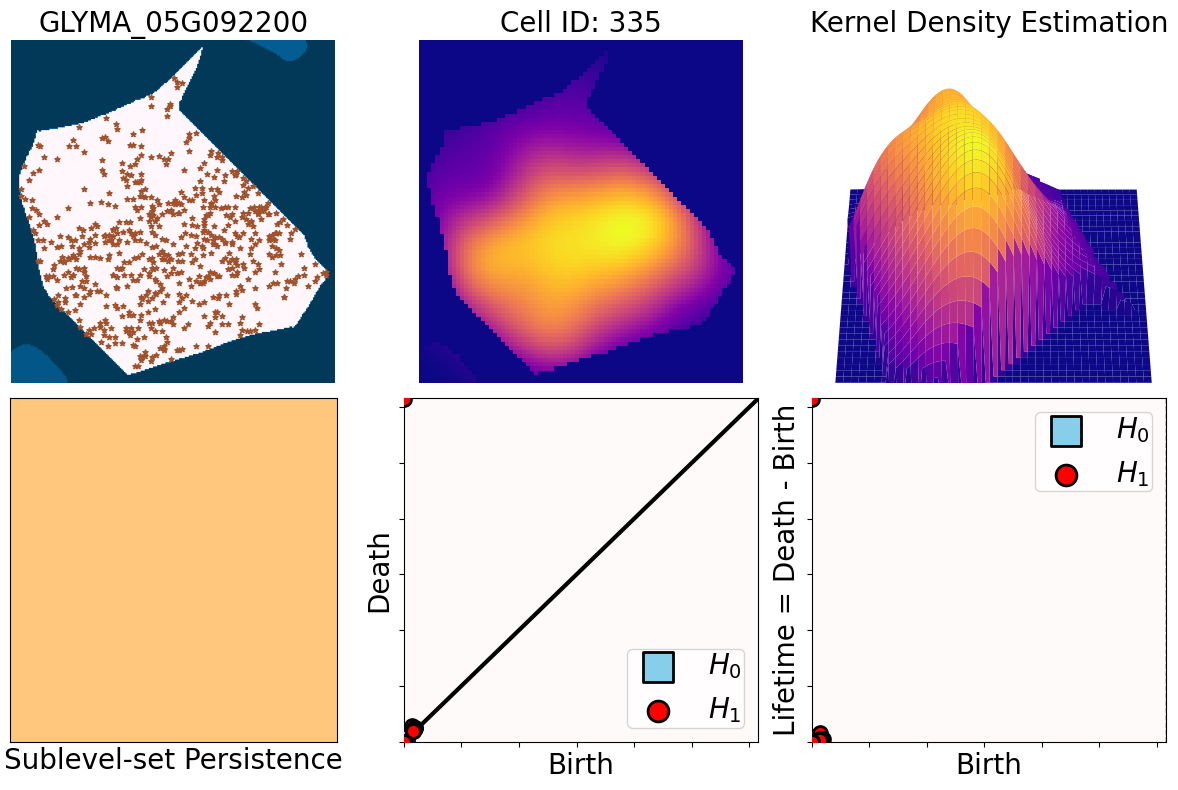

In [155]:
fs = 20
s,S = 15, 100
i = 40

ii = min(i, len(zthr) - 1)
pirange = int(np.round(i * len(pimg)/len(zthr)))
ppimg = np.zeros_like(pimg)
plane = np.zeros_like(kde) + zthr[ii]
heat = kde.copy()
heat[kde > zthr[ii]] = zthr[ii]

fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(2, 3, 1)
ax.imshow(cell, cmap='PuBu_r', origin='lower', extent=extent)
ax.scatter(*ccoords, c='sienna', marker='*', s=s, zorder=3)
ax.set_title(transcriptomes[tidx], fontsize=fs);

ax = fig.add_subplot(2, 3, 2)
ax.imshow(kde, cmap='plasma', origin='lower', extent=extent)
ax.set_title('Cell ID: {}'.format(metacell.loc[cidx, 'orig_cellID']), fontsize=fs)

ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.plot_surface(X, Y, heat, cmap='plasma', zorder=2, vmax=kde.max())
if i < len(zthr):
    ax.plot_surface(X, Y, plane, color='limegreen', alpha=0.25, zorder=3)
ax.set_zlim(zthr[0], zthr[-1])
ax.view_init(elev=45, azim=azim[i%len(azim)], roll=0)
ax.set_box_aspect(aspect=(4,4,3), zoom=1.65)
ax.set_title('Kernel Density Estimation', fontsize=fs);

ax = fig.add_subplot(2, 3, 4)
ax.imshow( kde <= zthr[ii], cmap='copper', origin='lower', vmin=0, vmax=1, zorder=1)
ax.set_xlabel('Sublevel-set Persistence', fontsize=fs);
ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)

ax = fig.add_subplot(2,3,5)
ax.axline((0,0), slope=1, c='k', lw=3, zorder=1)
if i < len(zthr):
    ax.plot([0, zthr[ii], zthr[ii]],[zthr[ii], zthr[ii], 0], lw=1, c='k', ls='--', zorder=2)
ax.set_xlim(0, zthr[-1]); ax.set_ylim(0, zthr[-1])

h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h0 = ax.scatter(*h, marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
h1 = ax.scatter(*h, marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')

ax.set_xlabel('Birth', fontsize=fs)
ax.set_ylabel('Death', fontsize=fs)
ax.set_facecolor('snow')
ax.legend([h0,h1],['$H_0$', '$H_1$'], loc='lower right', fontsize=fs, borderpad=0.1, markerscale=1.5)
ax.tick_params(labelbottom=False, labelleft=False)

ax = fig.add_subplot(2,3,6)

ax.axvline(zthr[ii], c='k', lw=1, zorder=2, ls='--')
h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
ax.scatter(h[0], h[1]-h[0], marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
ax.scatter(h[0], h[1]-h[0], marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')

ax.set_xlabel('Birth', fontsize=fs)
ax.set_ylabel('Lifetime = Death - Birth', fontsize=fs)
ax.set_facecolor('snow')
ax.legend([h0,h1],['$H_0$', '$H_1$'], loc='upper right', fontsize=fs, borderpad=0.1, markerscale=1.5)
ax.tick_params(labelbottom=False, labelleft=False)
ax.set_xlim(0, zthr[-1]); ax.set_ylim(0, zthr[-1])

if False:
    for j in range(pirange):
        for k in range(pirange-j):
            jj = min(j, ppimg.shape[0]-1)
            kk = min(k, ppimg.shape[1]-1)
            ppimg[jj, kk] = pimg[jj, kk]        
    ax.imshow(ppimg, origin='lower', cmap='Blues', vmax=pimg.max(), vmin=0, extent=(0,len(pimg),0,len(pimg)))
    ax.axline( ((i+1.75) * len(pimg)/len(zthr),0), slope=-1, c='gray', ls='--');
    ax.set_xlim(0, len(pimg));ax.set_ylim(0, len(pimg));
    ax.set_xlabel('Persistence Images', fontsize=fs);
    ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    for j in range(pirange):
        for k in range(pirange-j):
            if (j < ppimg.shape[0]) & (k < ppimg.shape[1]):
                if pimg[k,j] <= 1:
                    ax.text(j+.5, k+.5, '{}'.format(int(50*pimg[k,j])), color='k', ha='center', va='center_baseline', weight='bold', size=10.5)
                else:
                    ax.text(j+.5, k+.5, '{}'.format(int(50*pimg[k,j])), color='yellow', ha='center', va='center_baseline', weight='bold', size=10.5)

for a in fig.get_axes()[:3]:
    a.axis('off')
    
fig.tight_layout()

In [112]:
fs = 20
s,S = 15, 100
i = 16

for i in range(len(zthr)+1):
    
    ii = min(i, len(zthr) - 1)
    pirange = int(np.round(i * len(pimg)/len(zthr)))
    ppimg = np.zeros_like(pimg)
    plane = np.zeros_like(kde) + zthr[ii]
    heat = kde.copy()
    heat[kde > zthr[ii]] = zthr[ii]
    
    fig = plt.figure(figsize=(12,8))
    
    ax = fig.add_subplot(2, 3, 1)
    ax.imshow(cell, cmap='PuBu_r', origin='lower', extent=extent)
    ax.scatter(*ccoords, c='sienna', marker='*', s=s, zorder=3)
    ax.set_title(transcriptomes[tidx], fontsize=fs);
    
    ax = fig.add_subplot(2, 3, 2)
    ax.imshow(kde, cmap='plasma', origin='lower', extent=extent)
    ax.set_title('Cell ID: {}'.format(metacell.loc[cidx, 'orig_cellID']), fontsize=fs)
    
    ax = fig.add_subplot(2, 3, 3, projection='3d')
    ax.plot_surface(X, Y, heat, cmap='plasma', zorder=2, vmax=kde.max())
    if i < len(zthr):
        ax.plot_surface(X, Y, plane, color='limegreen', alpha=0.25, zorder=3)
    ax.set_zlim(zthr[0], zthr[-1])
    ax.view_init(elev=45, azim=azim[i%len(azim)], roll=0)
    ax.set_box_aspect(aspect=(4,4,3), zoom=1.65)
    ax.set_title('Kernel Density Estimation', fontsize=fs);
    
    ax = fig.add_subplot(2, 3, 4)
    ax.imshow( kde <= zthr[ii], cmap='copper', origin='lower', vmin=0, vmax=1, zorder=1)
    ax.set_xlabel('Sublevel-set Persistence', fontsize=fs);
    ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    
    ax = fig.add_subplot(2,3,5)
    ax.axline((0,0), slope=1, c='k', lw=3, zorder=1)
    if i < len(zthr):
        ax.plot([0, zthr[ii], zthr[ii]],[zthr[ii], zthr[ii], 0], lw=1, c='k', ls='--', zorder=2)
    ax.set_xlim(0, zthr[-1]); ax.set_ylim(0, zthr[-1])
    
    h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
    h0 = ax.scatter(*h, marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
    
    h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
    h1 = ax.scatter(*h, marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')
    
    ax.set_xlabel('Birth', fontsize=fs)
    ax.set_ylabel('Death', fontsize=fs)
    ax.set_facecolor('snow')
    ax.legend([h0,h1],['$H_0$', '$H_1$'], loc='lower right', fontsize=fs, borderpad=0.1, markerscale=1.5)
    ax.tick_params(labelbottom=False, labelleft=False)
    
    ax = fig.add_subplot(2,3,6)
    ax.axvline(zthr[ii], c='k', lw=1, zorder=2, ls='--')

    h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
    ax.scatter(h[0], h[1]-h[0], marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
    h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
    ax.scatter(h[0], h[1]-h[0], marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')
    
    ax.set_xlabel('Birth', fontsize=fs)
    ax.set_ylabel('Lifetime = Death - Birth', fontsize=fs)
    ax.set_facecolor('snow')
    ax.legend([h0,h1],['$H_0$', '$H_1$'], loc='upper right', fontsize=fs, borderpad=0.1, markerscale=1.5)
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.set_xlim(0, zthr[-1]); ax.set_ylim(0, zthr[-1])
    
    if False:
        for j in range(pirange):
            for k in range(pirange-j):
                jj = min(j, ppimg.shape[0]-1)
                kk = min(k, ppimg.shape[1]-1)
                ppimg[jj, kk] = pimg[jj, kk]        
        ax.imshow(ppimg, origin='lower', cmap='Blues', vmax=pimg.max(), vmin=0, extent=(0,len(pimg),0,len(pimg)))
        ax.axline( ((i+1.75) * len(pimg)/len(zthr),0), slope=-1, c='gray', ls='--');
        ax.set_xlim(0, len(pimg));ax.set_ylim(0, len(pimg));
        ax.set_xlabel('Persistence Images', fontsize=fs);
        ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
        for j in range(pirange):
            for k in range(pirange-j):
                if (j < ppimg.shape[0]) & (k < ppimg.shape[1]):
                    if pimg[k,j] <= 1:
                        ax.text(j+.5, k+.5, '{}'.format(int(50*pimg[k,j])), color='k', ha='center', va='center_baseline', weight='bold', size=10.5)
                    else:
                        ax.text(j+.5, k+.5, '{}'.format(int(50*pimg[k,j])), color='yellow', ha='center', va='center_baseline', weight='bold', size=10.5)

    for a in fig.get_axes()[:3]:
        a.axis('off')
        
    fig.tight_layout()
    
    filename = figdst + transcriptomes[tidx] + '_TDA_c{:05d}_{:02d}.png'.format(cidx, i)
    plt.savefig(filename, format='png', dpi=72, bbox_inches='tight')
    plt.close()

TypeError: object of type 'numpy.float64' has no len()

In [172]:
pirange

49

../animation/D2/GLYMA_05G092200_sublevel_c282/GLYMA_05G092200_TDA_c00282_122.png


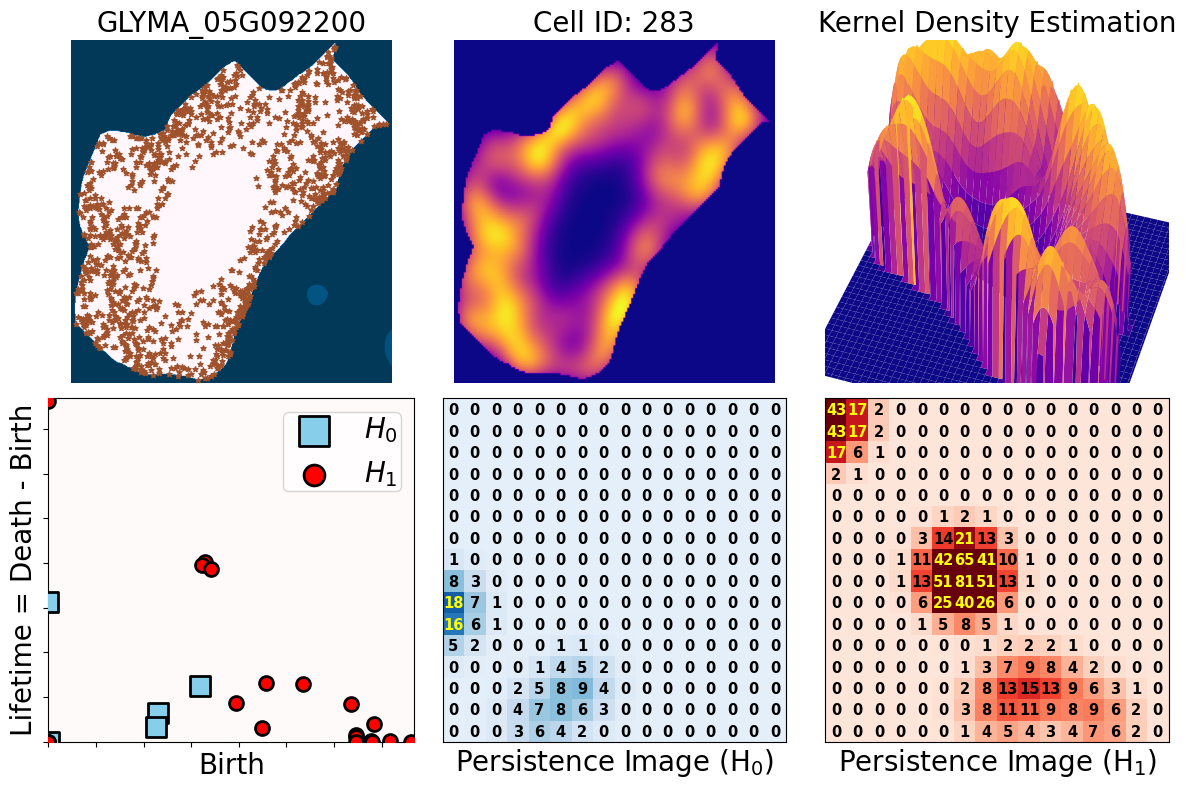

In [188]:
pimg_max = np.quantile(pimg[pimg > 0], 0.975)
i = 3*len(zthr) + 2

ii = min(i, len(zthr) - 1)
pirange = int(np.round(i * len(pimg[0])/len(zthr)))
ppimg = np.zeros_like(pimg)
plane = np.zeros_like(kde) + zthr[ii]
heat = kde.copy()
heat[kde > zthr[ii]] = zthr[ii]

fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(2, 3, 1)
ax.imshow(cell, cmap='PuBu_r', origin='lower', extent=extent)
ax.scatter(*ccoords, c='sienna', marker='*', s=s, zorder=3)
ax.set_title(transcriptomes[tidx], fontsize=fs);

ax = fig.add_subplot(2, 3, 2)
ax.imshow(kde, cmap='plasma', origin='lower', extent=extent)
ax.set_title('Cell ID: {}'.format(metacell.loc[cidx, 'orig_cellID']), fontsize=fs)

ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.plot_surface(X, Y, heat, cmap='plasma', zorder=2, vmax=kde.max())
if i < len(zthr):
    ax.plot_surface(X, Y, plane, color='limegreen', alpha=0.25, zorder=3)
ax.set_zlim(zthr[0], zthr[-1])
ax.view_init(elev=45, azim=azim[i%len(azim)], roll=0)
ax.set_box_aspect(aspect=(4,4,3), zoom=1.65)
ax.set_title('Kernel Density Estimation', fontsize=fs);

ax = fig.add_subplot(2, 3, 4)

h = bd.loc[ (bd['H'] == 0) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
ax.scatter(h[0], h[1]-h[0], marker='s', color='skyblue', edgecolor='k', linewidth=2, s=2*S, zorder=3, label='$H_0$')
h = bd.loc[ (bd['H'] == 1) & (bd['birth'] <= zthr[ii]) & (bd['death'] <= zthr[ii]), ['birth','death']].values.T
ax.scatter(h[0], h[1]-h[0], marker='o', color='red', edgecolor='k', linewidth=2, s=S, zorder=4, label='$H_1$')

ax.set_xlabel('Birth', fontsize=fs)
ax.set_ylabel('Lifetime = Death - Birth', fontsize=fs)
ax.set_facecolor('snow')
ax.legend([h0,h1],['$H_0$', '$H_1$'], loc='upper right', fontsize=fs, borderpad=0.1, markerscale=1.5)
ax.tick_params(labelbottom=False, labelleft=False)
ax.set_xlim(0, zthr[-1]); ax.set_ylim(0, zthr[-1])

ax = fig.add_subplot(2,3,5)

ax.imshow(pimg[0].T, origin='lower', cmap='Blues', vmin=-0.1*pimg_max, vmax=pimg_max, extent=(0,len(pimg[0]),0,len(pimg[0])))
ax.set_xlim(0, len(pimg[0]));ax.set_ylim(0, len(pimg[0]));
ax.set_xlabel('Persistence Image (H$_0$)', fontsize=fs);
ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
if i > 3*len(zthr):
    for j in range(pimg[0].shape[0]):
        for k in range(pimg[0].shape[1]):
            if 25*pimg[0,j,k] <= 16:
                ax.text(j+.5, k+.5, '{}'.format(int(25*pimg[0,j,k])), color='k', ha='center', va='center_baseline', weight='bold', size=10.5)
            else:
                ax.text(j+.5, k+.5, '{}'.format(int(25*pimg[0,j,k])), color='yellow', ha='center', va='center_baseline', weight='bold', size=10.5)


ax = fig.add_subplot(2,3,6)
      
ax.imshow(pimg[1].T, origin='lower', cmap='Reds', vmin=-0.1*pimg_max, vmax=pimg_max, extent=(0,len(pimg[1]),0,len(pimg[1])))
ax.set_xlim(0, len(pimg[1]));ax.set_ylim(0, len(pimg[1]));
ax.set_xlabel('Persistence Image (H$_1$)', fontsize=fs);
ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
if i > 3*len(zthr):
    for j in range(pimg[1].shape[0]):
        for k in range(pimg[1].shape[1]):
            if 25*pimg[1,j,k] <= 16:
                ax.text(j+.5, k+.5, '{}'.format(int(25*pimg[1,j,k])), color='k', ha='center', va='center_baseline', weight='bold', size=10.5)
            else:
                ax.text(j+.5, k+.5, '{}'.format(int(25*pimg[1,j,k])), color='yellow', ha='center', va='center_baseline', weight='bold', size=10.5)


for a in fig.get_axes()[:3]:
    a.axis('off')
    
fig.tight_layout()
filename = figdst + transcriptomes[tidx] + '_TDA_c{:05d}_{:03d}.png'.format(cidx, i)
print(filename)
plt.savefig(filename, format='png', dpi=72, bbox_inches='tight')

# Cubical persistence

- Cubical persistence computed with [`gudhi`](https://gudhi.inria.fr/), which does a decent job whenever images are less than 1000 x 1000 px in size.
- Persistence computed directly on 3D images produced by the KDE
- Played with both sublevel and superlevel filtrations
- Probably we'll stick with superlevel later down the line, as it is intuitively easier to explain and visualize.

In [134]:
if i > 3*len(zthr):
    for j in range(pimg[0].shape[0]):
        for k in range(pimg[0].shape[1]):
            if pimg[0,k,j] <= 1:
                ax.text(j+.5, k+.5, '{}'.format(int(25*pimg[0,k,j])), color='k', ha='center', va='center_baseline', weight='bold', size=10.5)
            else:
                ax.text(j+.5, k+.5, '{}'.format(int(25*pimg[0,k,j])), color='yellow', ha='center', va='center_baseline', weight='bold', size=10.5)


,birth,death
20,1.962083e-09,6.264967e-06
21,6.368319e-06,8.856922e-06
22,4.622853e-06,5.924859e-06
23,4.527073e-06,5.179866e-06
24,4.168074e-09,4.227741e-09


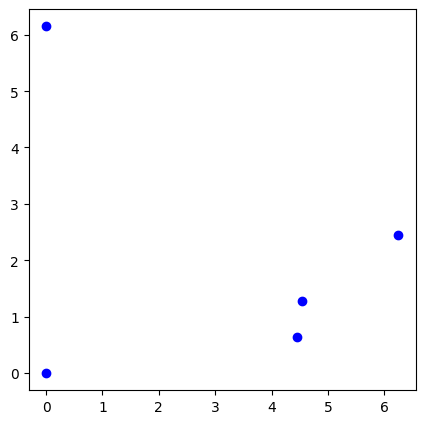

In [145]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

k = 0
ax[j].scatter(*(ld[k].T), marker='o', c='b')
ax[j].set_aspect('equal');

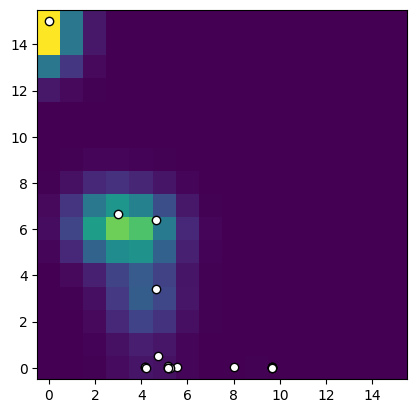

In [205]:
plt.imshow(pimg.T, origin='lower')
plt.scatter(ld[:,0], ld[:,1], marker='o', linewidth=1, edgecolor='k', color='w');

# What if we just want to focus on a subset of cells and genes?

In [25]:
cell_focus = pd.read_csv('../data/D2_data/infected_cells_ids.csv')
gene_focus = pd.read_csv('../data/D2_data/genes_to_focus_infection.csv')

if 'gene_ID' in gene_focus.columns:
    gid = gene_focus['gene_ID'].values
else:
    gid = np.zeros(len(gene_focus), dtype=int)
    for i in range(len(gid)):
        gid[i] = np.nonzero(transcriptomes == gene_focus.iloc[i,0])[0][0]
        
if 'ndimage_ID' in cell_focus.columns:
    cid = cell_focus['ndimage_ID'].values
else:
    cid = np.zeros(len(cell_focus), dtype=int)
    for i in range(len(cid)):
        cid[i] = metacell[metacell['orig_cellID'] == cell_focus.iloc[i,0]].index[0]